In [174]:
import ood_metrics
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
%load_ext autoreload
%autoreload 2

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
res = {}
for exp in ood_metrics.load_ood("ood_metric.jsonl"):
    encoder = exp["encoder"]
    size = exp["size"]
    type = exp["type"]
    score = exp["score"]
    dataset = exp["dataset"]
    reduce_level = exp["reduce_level"]
    aug_level = exp["aug_level"]
    train_name, train_auc, train_mean = score[0]
    test_name, test_auc, test_mean = score[1]
    ood_name, ood_auc, ood_mean = zip(*score[2:])
    ood_auc, ood_mean = np.mean(ood_auc), np.mean(ood_mean)
    score = 1 - ood_auc + abs(test_auc-0.5)
    res.setdefault(f"{encoder}_{dataset}_alvl{aug_level}_rlvl{reduce_level}_{type}_{size}", []).append(score.item())

for name, score in sorted(res.items(), key=lambda x: np.mean(x[1])):
    print(name, np.mean(score))


vit_BloodMNIST_alvl0_rlvl1_train_224 0.09800910768224134
vit_BloodMNIST_alvl0_rlvl1_test_224 0.098757739505405
dinov2_BloodMNIST_alvl0_rlvl1_train_224 0.14464823083077838
dinov2_BloodMNIST_alvl0_rlvl1_test_224 0.1489204103646299
resnet50_BloodMNIST_alvl0_rlvl1_train_224 0.1504456671463593
resnet50_BloodMNIST_alvl0_rlvl1_test_224 0.15178089158074926
vit_OrganCMNIST_alvl0_rlvl1_train_224 0.17488610129680532
vit_OrganCMNIST_alvl0_rlvl1_test_224 0.17533914532902645
dinov2_PathMNIST_alvl0_rlvl1_test_28 0.18143728513024404
clip_BloodMNIST_alvl0_rlvl1_test_224 0.18312348734257639
clip_OrganCMNIST_alvl0_rlvl1_train_224 0.1832194900980258
clip_BloodMNIST_alvl0_rlvl1_train_224 0.18394057627445126
clip_OrganCMNIST_alvl0_rlvl1_test_224 0.186230377272085
dinov2_PathMNIST_alvl0_rlvl1_train_28 0.1871230527895697
vit_BloodMNIST_alvl0_rlvl1_test_28 0.19087897361339623
clip_PathMNIST_alvl0_rlvl1_test_28 0.19387745124136624
vit_BloodMNIST_alvl0_rlvl1_train_28 0.19549839253014395
clip_PathMNIST_alvl0_rlvl

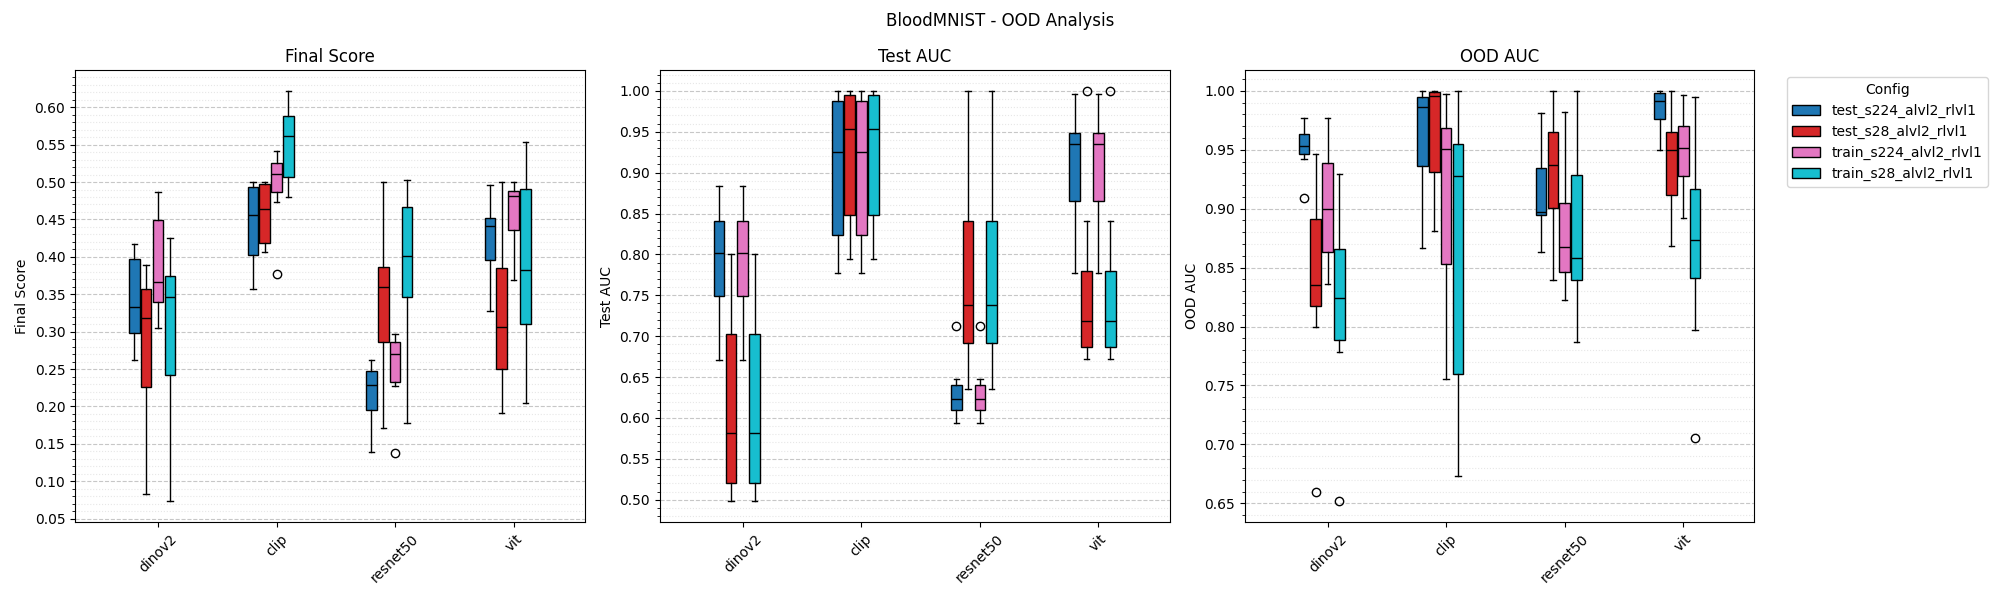

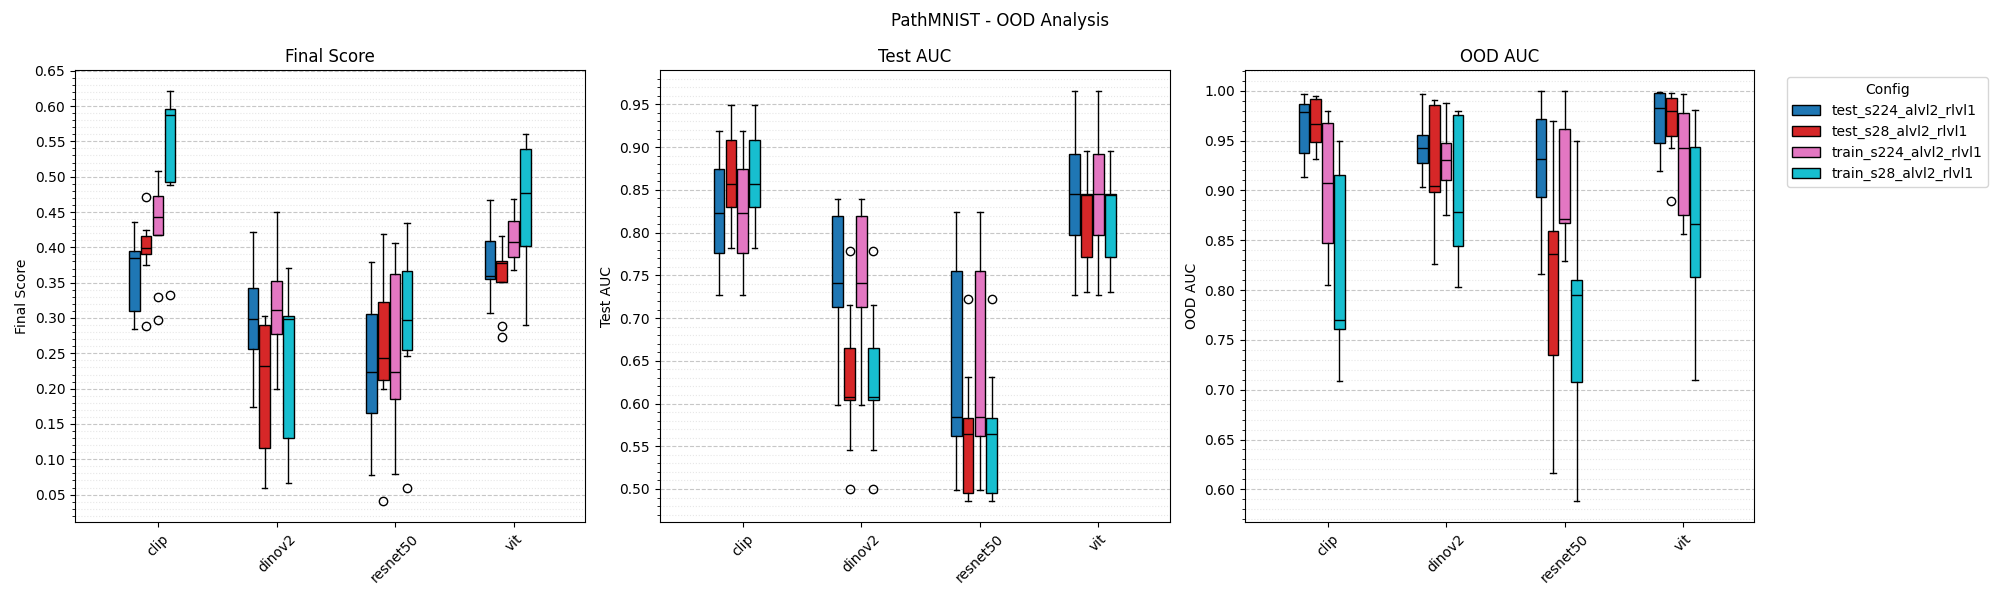

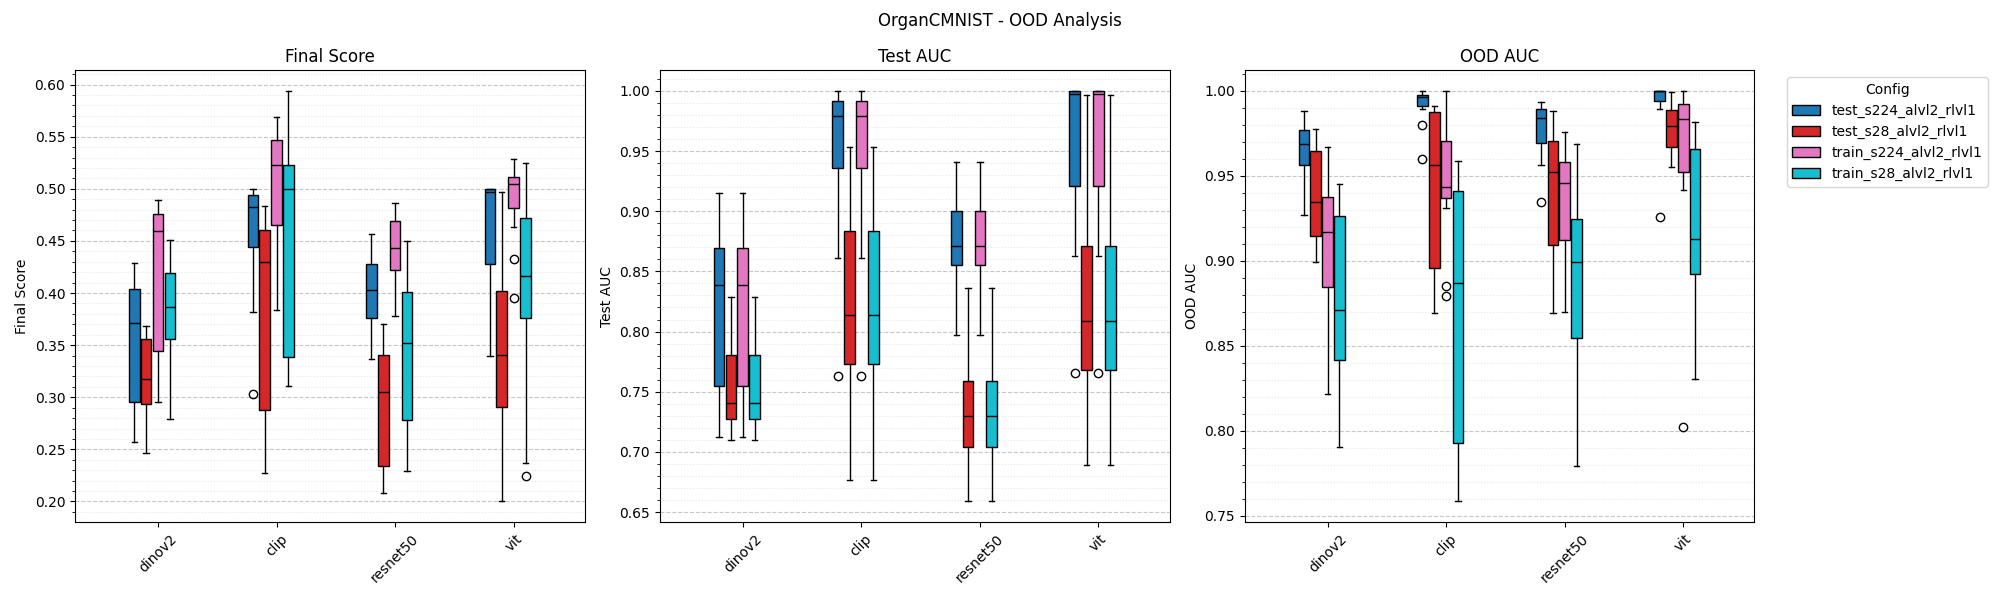

In [176]:

# Reorganize the loaded data
res = {}
for exp in ood_metrics.load_ood("ood_metric.jsonl"):
    encoder = exp["encoder"]
    size = exp["size"]
    type_ = exp["type"]
    score = exp["score"]
    dataset = exp["dataset"]
    reduce_level = exp["reduce_level"]
    aug_level = exp["aug_level"]
    train_name, train_auc, train_mean = score[0]
    test_name, test_auc, test_mean = score[1]
    ood_name, ood_auc, ood_mean = zip(*score[2:])
    ood_auc = np.mean(ood_auc)
    ood_mean = np.mean(ood_mean)
    final_score = 1 - ood_auc + abs(test_auc - 0.5)
    if reduce_level != 1:
        continue
    if aug_level != 2:
        continue
    res.setdefault(f"{encoder}_{dataset}_{aug_level}_{reduce_level}_{type_}_{size}", []).append((final_score, test_auc, ood_auc))

# Step 2: Reorganize data -> dataset -> encoder -> config -> [(final_score, test_auc, ood_auc)]
reorganized_res = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for key, values in res.items():
    encoder, dataset, aug_level, reduce_level, type_, size = key.split("_")
    cfg = (type_, size, aug_level, reduce_level)
    for value in values:
        reorganized_res[dataset][encoder][cfg].append(value)

# Step 3: Plot 3 subplots per dataset
for dataset, encoders in reorganized_res.items():
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)
    metric_names = ['Final Score', 'Test AUC', 'OOD AUC']
    metric_idx = [0, 1, 2]

    encoder_list = list(encoders.keys())
    encoder_positions = np.arange(len(encoder_list))
    config_set = sorted({cfg for encoder_data in encoders.values() for cfg in encoder_data})
    width = 0.1

    # Assign colors
    color_map = plt.cm.tab10(np.linspace(0, 1, len(config_set)))
    config_colors = {cfg: color for cfg, color in zip(config_set, color_map)}

    for ax, metric_name, idx in zip(axes, metric_names, metric_idx):
        positions = []
        box_data = []
        labels = []

        for e_idx, encoder in enumerate(encoder_list):
            config_data = encoders[encoder]
            for i, cfg in enumerate(config_set):
                values = [val[idx] for val in config_data.get(cfg, [])]
                if values:
                    pos = e_idx + (i - len(config_set)/2) * width
                    positions.append(pos)
                    box_data.append(values)
                    labels.append(f'{encoder}\n{cfg[0]}_s{cfg[1]}_alvl{cfg[2]}_rlvl{cfg[3]}')

        # Boxplot
        bp = ax.boxplot(
            box_data,
            positions=positions,
            patch_artist=True,
            widths=width * 0.9,
            showfliers=True,
            medianprops=dict(color='black')
        )

        for i, patch in enumerate(bp['boxes']):
            cfg_idx = i % len(config_set)
            patch.set_facecolor(color_map[cfg_idx])

        ax.set_title(metric_name)
        ax.set_ylabel(metric_name)
        ax.set_xticks(encoder_positions)
        ax.set_xticklabels(encoder_list, rotation=45)
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
        ax.grid(which='major', axis='y', linestyle='--', alpha=0.7)
        ax.grid(which='minor', axis='y', linestyle=':', alpha=0.3)

    # Add legend
    legend_handles = [
        Patch(facecolor=color, edgecolor='black', label=f"{cfg[0]}_s{cfg[1]}_alvl{cfg[2]}_rlvl{cfg[3]}")
        for cfg, color in config_colors.items()
    ]
    axes[-1].legend(handles=legend_handles, title="Config", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f"{dataset} - OOD Analysis")
    plt.tight_layout()
    plt.show()